In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('godoy-aula-4').getOrCreate()
# spark = SparkSession \
#             .builder \
#             .master("local[1]") \
#             .appName("godoy-aula-4") \
#             .config("spark.executor.memory", "3g") \
#             .config("spark.driver.memory", "2g") \
#             .config("spark.executor.cores", "2") \
#             .config("spark.cores.max", "2") \
#             .getOrCreate()

In [2]:
spark.sparkContext

<SparkContext master=local[*] appName=godoy-aula-4>

In [3]:
df = spark.read\
        .format("json")\
        .option("header", "true")\
        .load("amazon-music-reviews.json")

In [4]:
def pshow(sparkDf, limit=10):
    return sparkDf.limit(limit).toPandas()

In [5]:
pshow(df.describe("asin"))

,summary,asin
0,count,64706
1,mean,5.555991584E9
2,stddev,0.0
3,min,5555991584
4,max,B00KILDVEI


In [6]:
pshow(
    df.select("asin").limit(3)
)

,asin
0,5555991584
1,5555991584
2,5555991584


In [7]:
pshow(df)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5.0,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4.0,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000
5,5555991584,"[62, 65]",5.0,Who knows why I initially considered this to b...,"07 30, 2003",A2P49WD75WHAG5,Daniel J. Hamlow,Dreamy unearthly magic continues with Eire's o...,1059523200
6,5555991584,"[1, 5]",3.0,Enya is one of a few artists whom I consider s...,"05 27, 2000",A3O90G1D7I5EGG,dev1,Have You Hugged A Tree Today?,959385600
7,5555991584,"[5, 5]",5.0,Enya is one of of the most mysterious singers ...,"12 21, 2002",A3EJYJC25OJVKK,"Distant Voyageur ""Nicholas Computer""",The album for a romantic autumn evening,1040428800
8,5555991584,"[4, 4]",5.0,This is not another lousy Celtic New Age album...,"01 4, 2007",A1DA8VOH9NR6C7,E. Minkovitch,Simply wonderful.,1167868800
9,5555991584,"[12, 12]",5.0,"Many times, AND WITH GOOD REASON, the ""new age...","05 12, 2003",A33TRNCQK4IUO7,guillermoj,"A true gem, even if you don't love conventiona...",1052697600


In [8]:
filter_rosemary = (df["reviewerName"] == "Rosemary")
filter_4_5 = (df["overall"] == 4) | (df["overall"] == 5)
df_rose = df.filter(filter_rosemary  & filter_4_5)

pshow(df_rose)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B006VRG3K2,"[0, 0]",5.0,This is relaxing. It is good to wind down to ...,"02 19, 2013",A3BZE98FY9G5F2,Rosemary,MUSIC is good,1361232000
1,B007DIQAXI,"[0, 0]",5.0,Some people are just good at what they do...th...,"06 20, 2013",A3BZE98FY9G5F2,Rosemary,It is worth the money,1371686400
2,B00B3BE4Z2,"[0, 0]",4.0,I enjoy listening to it. It is easy to get to...,"05 2, 2013",A3BZE98FY9G5F2,Rosemary,BRIGHT STARS BURNING is a catchy title,1367452800
3,B00FAEPGA0,"[0, 0]",4.0,It is worth the money.It is relaxing to listen...,"03 7, 2014",A3BZE98FY9G5F2,Rosemary,GOOD NIGHT,1394150400


In [9]:
df_rose.count()

4

In [10]:
df_reviews = df.orderBy("reviewerName").groupBy("reviewerName", "overall").count()

In [12]:
pshow(df_reviews)

,reviewerName,overall,count
0,TM,5.0,7
1,"! MR. KNOW IT ALL ;-b ""DR SHOCK""",5.0,4
2,"! MR. KNOW IT ALL ;-b ""DR SHOCK""",3.0,2
3,"! Metamorpho ;) ""Reflective and Wiser Seer""",5.0,27
4,"! Metamorpho ;) ""Reflective and Wiser Seer""",4.0,1
5,"!hype 2007 ""!hype""",5.0,4
6,"!hype 2007 ""!hype""",4.0,1
7,"""-_mystikal_-""",5.0,4
8,"""-_mystikal_-""",4.0,1
9,"""Johnny Salzone""",4.0,2


# UDF
User defined functions

In [13]:
def helpful_rate(helpful):
    numerator = float(helpful[0])
    denominator = float(helpful[1])
    if denominator == 0:
        return 0.0
    return (numerator/denominator)

In [14]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

helpful_rate_udf = F.udf(helpful_rate, DoubleType())

In [15]:
review = df
review_with_hrate = review.withColumn("helpfulRate",
                                         helpful_rate_udf(review["helpful"]))
review_with_hrate.limit(3).toPandas()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,helpfulRate
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,1.0
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,0.0
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,1.0


In [16]:
from datetime import datetime
datetime.fromtimestamp(int("1158019200"))

datetime.datetime(2006, 9, 12, 0, 0)

In [17]:
from pyspark.sql.types import IntegerType

def get_year(unixReviewTime):
    return datetime.fromtimestamp(int(unixReviewTime)).year

get_year_udf = F.udf(get_year, IntegerType())

In [19]:
review_with_hrate = review.withColumn("reviewYear", get_year_udf(review["unixReviewTime"]))
pshow(review_with_hrate, 3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewYear
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,2006
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,2001
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,2003


# Pivoteamento em um Dataframe

Operação cara

In [21]:
pivoted = review_with_hrate.groupBy("reviewerID").pivot("asin").avg("overall")

In [23]:
pivoted.limit(3).toPandas()

,reviewerID,5555991584,B0000000ZW,B00000016T,B00000016W,B00000017R,B0000001P4,B0000002HZ,B0000002J9,B0000002JR,...,B00II5VHBU,B00IOVH8AW,B00IXZ9QP4,B00J80ED9M,B00JJCQRDE,B00JJOG5D4,B00JRBLSR2,B00JTHVWO8,B00JYKU6BK,B00KILDVEI
0,A3URRZ02P8KLWM,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,AZSACV427GIAH,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,A1EG35C531ISHN,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


**Usar persist para armazenar o dataframe, e nao reprocessar**

In [24]:
# pivoted.filter(pivoted["reviewerID"] == "AZSACV427GIAH").toPandas()

# Teste AB com Spark

In [36]:
ab_result = spark.read.format("csv").option("header", "true").load("ab_test.csv")

In [37]:
ab_result.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- experiment: string (nullable = true)
 |-- alternative: string (nullable = true)
 |-- conversion: string (nullable = true)



In [38]:
pshow(ab_result)

,_c0,userId,experiment,alternative,conversion
0,0,A1FW17CFR34TKF,ab_test,A,1
1,1,A2ZAEMRNIA7PV6,ab_test,A,0
2,2,AZ39SOZT3NZQU,ab_test,A,0
3,3,ARPRJZSXOZO2V,ab_test,A,0
4,4,A1F3GOUFG7Y73U,ab_test,B,0
5,5,AN092R6OZE3U0,ab_test,B,1
6,6,A1LWYVLGA3N2R4,ab_test,B,0
7,7,A33B5M5CE7ZX7C,ab_test,B,0
8,8,A1PULJNO1T3YVX,ab_test,B,0
9,9,A22N03OBDDVSEB,ab_test,A,0


In [40]:
ab_result = ab_result.withColumn("conversion", ab_result["conversion"].cast("boolean"))
pshow(ab_result)

,_c0,userId,experiment,alternative,conversion
0,0,A1FW17CFR34TKF,ab_test,A,True
1,1,A2ZAEMRNIA7PV6,ab_test,A,False
2,2,AZ39SOZT3NZQU,ab_test,A,False
3,3,ARPRJZSXOZO2V,ab_test,A,False
4,4,A1F3GOUFG7Y73U,ab_test,B,False
5,5,AN092R6OZE3U0,ab_test,B,True
6,6,A1LWYVLGA3N2R4,ab_test,B,False
7,7,A33B5M5CE7ZX7C,ab_test,B,False
8,8,A1PULJNO1T3YVX,ab_test,B,False
9,9,A22N03OBDDVSEB,ab_test,A,False


In [44]:
ab_result.groupBy("experiment", "alternative").count().show()

+----------+-----------+-----+
|experiment|alternative|count|
+----------+-----------+-----+
|   ab_test|          A| 2849|
|   ab_test|          B| 2687|
+----------+-----------+-----+



In [70]:
ab_distribution = ab_result.groupBy("experiment", "alternative").count().collect()
ab_distribution

[Row(experiment='ab_test', alternative='A', count=2849),
 Row(experiment='ab_test', alternative='B', count=2687)]

In [71]:
labels = []
values = []
for row in ab_distribution:
    alternative = row["alternative"]
    count = row["count"]
    labels.append(alternative)
    values.append(count)


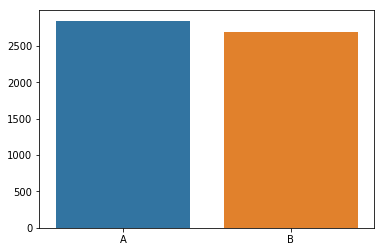

In [72]:
%matplotlib inline
import seaborn as sns

sns.barplot(labels,values)

In [86]:

ab_result.groupBy("userId", "alternative").count().filter("count != 1").show()

+------+-----------+-----+
|userId|alternative|count|
+------+-----------+-----+
+------+-----------+-----+



In [87]:
ab_result_c_long = ab_result.withColumn("conversion_long",
                                       ab_result["conversion"].cast("long"))

In [93]:
ab_result_conversion = ab_result_c_long.groupBy("alternative") \
                                        .agg(
                                            F.sum(ab_result_c_long["conversion_long"]) \
                                            .alias("conversion_count")
                                        )
pshow(ab_result_conversion)

,alternative,conversion_count
0,B,922
1,A,1120


In [94]:
# ab_result_conversion = ab_result.groupBy("alternative").agg(
# F.fun())

In [97]:
tax = ab_result.groupBy("alternative") \
        .agg(
            F.count("*").alias("impressions"),
            F.sum(ab_result["conversion"].cast("long")).alias("conversions")
        )

In [98]:
pshow(tax)

,alternative,impressions,conversions
0,B,2687,922
1,A,2849,1120


Processa de hora em hora o delta de 1h. Por exemplo, às 17h processa os dados entre 16h às 17h.

In [99]:
from pyspark.sql.types import DoubleType

def conversion_tax(imp, conv):
    i = float(imp)
    c = float(conv)
    return c/i

conversion_tax_udf = F.udf(conversion_tax, DoubleType())

In [117]:
with_tax = tax.withColumn("tax", conversion_tax_udf(tax["impressions"], tax["conversions"]))\
    .orderBy("alternative")
pshow(with_tax)

,alternative,impressions,conversions,tax
0,A,2849,1120,0.393120
1,B,2687,922,0.343134


# Análise profunda - enriquecimento do dado

In [110]:
columns = ["id", "nome"]
vals = [
    (1, "aluno1"),
    (2, "aluno2"),
    (5, "aluno5"),
    (6, "aluno6")
]
df_aluno = spark.createDataFrame(vals, columns)

In [111]:
pshow(df_aluno)

,id,nome
0,1,aluno1
1,2,aluno2
2,5,aluno5
3,6,aluno6


In [112]:
columns = ["id", "rua", "num", "cep", "aluno_id"]
vals = [
    (1, "rua a", "34", "32340-234", 1),
    (2, "rua a", "1523", "32240-134", 2),
    (3, "rua b", "23", "32340-234", 5),
    (4, "rua c", "13", "32340-234", 6)
]
df_enderecos = spark.createDataFrame(vals, columns)

In [113]:
pshow(df_enderecos)

,id,rua,num,cep,aluno_id
0,1,rua a,34,32340-234,1
1,2,rua a,1523,32240-134,2
2,3,rua b,23,32340-234,5
3,4,rua c,13,32340-234,6


In [114]:
df_aluno.join(df_enderecos, df_aluno["id"] == df_enderecos["id"], "left").show()

+---+------+----+-----+----+---------+--------+
| id|  nome|  id|  rua| num|      cep|aluno_id|
+---+------+----+-----+----+---------+--------+
|  6|aluno6|null| null|null|     null|    null|
|  5|aluno5|null| null|null|     null|    null|
|  1|aluno1|   1|rua a|  34|32340-234|       1|
|  2|aluno2|   2|rua a|1523|32240-134|       2|
+---+------+----+-----+----+---------+--------+



In [120]:
pshow(df, 5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5.0,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4.0,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000


In [121]:
pshow(ab_result, 5)

,_c0,userId,experiment,alternative,conversion
0,0,A1FW17CFR34TKF,ab_test,A,True
1,1,A2ZAEMRNIA7PV6,ab_test,A,False
2,2,AZ39SOZT3NZQU,ab_test,A,False
3,3,ARPRJZSXOZO2V,ab_test,A,False
4,4,A1F3GOUFG7Y73U,ab_test,B,False


In [126]:
joined_reviews_ab = df.join(ab_result, df["reviewerID"] == ab_result["userId"], "left")
pshow(joined_reviews_ab, 3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,_c0,userId,experiment,alternative,conversion
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,267,A3EBHHCZO6V2A4,ab_test,A,False
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,3271,AZPWAXJG9OJXV,ab_test,A,True
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,680,A38IRL0X2T4DPF,ab_test,A,True


In [136]:
pshow(joined_reviews_ab.describe("alternative"))

,summary,alternative
0,count,64681
1,mean,None
2,stddev,None
3,min,A
4,max,B


In [137]:
overall_mean_by_alternative = joined_reviews_ab.groupBy("alternative").agg(
    F.mean("overall").alias("overall_mean")
)

In [138]:
pshow(overall_mean_by_alternative)

,alternative,overall_mean
0,None,4.520000
1,B,4.224297
2,A,4.220563


In [142]:
joined_reviews_ab.filter("alternative is not null") \
    .groupBy("alternative") \
    .agg(
        F.mean("overall").alias("overall_mean")
    ).show()

+-----------+-----------------+
|alternative|     overall_mean|
+-----------+-----------------+
|          B|4.224297302395774|
|          A|4.220562737642585|
+-----------+-----------------+



In [144]:
from pyspark.sql.functions import from_unixtime

joined_formated = joined_reviews_ab.withColumn("date", from_unixtime(joined_reviews_ab["unixReviewTime"], format="MM/dd"))

In [145]:
pshow(joined_formated)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,_c0,userId,experiment,alternative,conversion,date
0,5555991584,"[3, 3]",5.0,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200,267,A3EBHHCZO6V2A4,ab_test,A,False,09/12
1,5555991584,"[0, 0]",5.0,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400,3271,AZPWAXJG9OJXV,ab_test,A,True,06/03
2,5555991584,"[2, 2]",5.0,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800,680,A38IRL0X2T4DPF,ab_test,A,True,07/14
3,5555991584,"[1, 1]",5.0,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000,5405,A22IK3I6U76GX0,ab_test,B,True,05/03
4,5555991584,"[1, 1]",4.0,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000,4744,A1AISPOIIHTHXX,ab_test,B,False,01/17
5,5555991584,"[62, 65]",5.0,Who knows why I initially considered this to b...,"07 30, 2003",A2P49WD75WHAG5,Daniel J. Hamlow,Dreamy unearthly magic continues with Eire's o...,1059523200,759,A2P49WD75WHAG5,ab_test,B,False,07/30
6,5555991584,"[1, 5]",3.0,Enya is one of a few artists whom I consider s...,"05 27, 2000",A3O90G1D7I5EGG,dev1,Have You Hugged A Tree Today?,959385600,1870,A3O90G1D7I5EGG,ab_test,B,True,05/27
7,5555991584,"[5, 5]",5.0,Enya is one of of the most mysterious singers ...,"12 21, 2002",A3EJYJC25OJVKK,"Distant Voyageur ""Nicholas Computer""",The album for a romantic autumn evening,1040428800,400,A3EJYJC25OJVKK,ab_test,A,False,12/21
8,5555991584,"[4, 4]",5.0,This is not another lousy Celtic New Age album...,"01 4, 2007",A1DA8VOH9NR6C7,E. Minkovitch,Simply wonderful.,1167868800,3822,A1DA8VOH9NR6C7,ab_test,B,True,01/04
9,5555991584,"[12, 12]",5.0,"Many times, AND WITH GOOD REASON, the ""new age...","05 12, 2003",A33TRNCQK4IUO7,guillermoj,"A true gem, even if you don't love conventiona...",1052697600,3311,A33TRNCQK4IUO7,ab_test,A,True,05/12


In [146]:
joined_formated.select("date").distinct().orderBy("date").show(5)

+-----+
| date|
+-----+
|01/01|
|01/02|
|01/03|
|01/04|
|01/05|
+-----+
only showing top 5 rows

